In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes()

In [2]:
SEED = 1234567890

np.random.seed(SEED)

In [3]:
%%bash
DATA_URI=https://raw.githubusercontent.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/master/Data/rugged.csv
DATA_DEST=/tmp/rugged.csv

if [ ! -e ${DATA_DEST} ]
then
    wget -qO ${DATA_DEST} ${DATA_URI}
        
fi

#### Code 8.1

In [4]:
num_weeks = int(1e5)
positions = np.empty(num_weeks, dtype=np.int64)
current = 9

for i in range(num_weeks):
    # record current position
    positions[i] = current

    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # now make sure he loops around the archipelago
    proposal %= 10
    
    #move?
    prob_move = (proposal + 1) / (current + 1)
    current = proposal if np.random.uniform() < prob_move else current

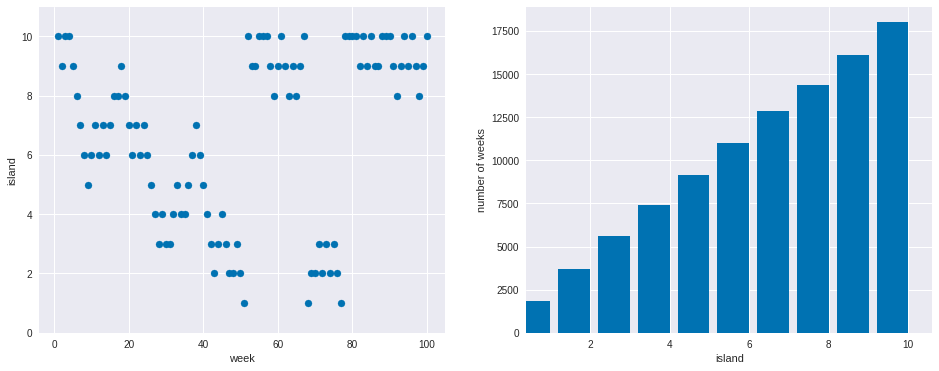

In [5]:
_, (week_ax, island_ax) = plt.subplots(ncols=2, figsize=(16, 6))

week_ax.scatter(np.arange(100) + 1, positions[:100] + 1);

week_ax.set_xlabel('week');
week_ax.set_ylim(0, 11);
week_ax.set_ylabel('island');

island_ax.bar(np.arange(10) + 0.6, np.bincount(positions));

island_ax.set_xlim(0.4, 10.6);
island_ax.set_xlabel('island');
island_ax.set_ylabel('number of weeks');

#### Code 8.2

In [6]:
rugged_df = (pd.read_csv('/tmp/rugged.csv', sep=';')
               .assign(log_gdp=lambda df: np.log(df.rgdppc_2000))
               .dropna(subset=['log_gdp']))

#### Code 8.3

In [7]:
with pm.Model() as m8_1_map:
    a = pm.Normal('a', 0., 100.)
    bR = pm.Normal('bR', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bAR = pm.Normal('bAR', 0., 10.)
    mu = a \
            + bR * rugged_df.rugged \
            + bA * rugged_df.cont_africa \
            + bAR * rugged_df.rugged * rugged_df.cont_africa
    
    sigma = pm.Uniform('sigma', 0., 10.)
    
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=rugged_df.log_gdp)

In [8]:
with m8_1_map:
    map_8_1 = pm.find_MAP()

logp = -246.89, ||grad|| = 0.297: 100%|██████████| 36/36 [00:00<00:00, 645.51it/s]s]].39it/s]


In [9]:
map_8_1

{'a': array(9.222789236008568),
 'bA': array(-1.9469463402783405),
 'bAR': array(0.3929043459613421),
 'bR': array(-0.2026534571338184),
 'sigma': array(0.932678798151842),
 'sigma_interval__': array(-2.274371278607129)}

#### Code 8.5

In [10]:
with pm.Model() as m8_1:
    a = pm.Normal('a', 0., 100.)
    bR = pm.Normal('bR', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bAR = pm.Normal('bAR', 0., 10.)
    mu = a \
            + bR * rugged_df.rugged \
            + bA * rugged_df.cont_africa \
            + bAR * rugged_df.rugged * rugged_df.cont_africa
    
    sigma = pm.HalfCauchy('sigma', 2.)
    
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=rugged_df.log_gdp)

In [11]:
with  m8_1:
    trace_8_1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:03<00:00, 391.99it/s]


In [12]:
pm.df_summary(trace_8_1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,9.227104,0.147184,0.007083,8.942388,9.505687
bR,-0.203419,0.082340,0.004010,-0.357060,-0.041450
bA,-1.947706,0.242981,0.011398,-2.462145,-1.503691
bAR,0.395830,0.138579,0.006786,0.100679,0.658840
sigma,0.951097,0.052000,0.001769,0.846561,1.051271


#### Code 8.7

In [13]:
with m8_1:
    trace_8_1_4_chains = pm.sample(1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:06<00:00, 218.84it/s]


In [14]:
pm.df_summary(trace_8_1_4_chains)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,9.223029,0.144147,0.003174,8.934266,9.493333
bR,-0.203055,0.079153,0.001834,-0.362643,-0.054523
bA,-1.947522,0.230088,0.004750,-2.392139,-1.503176
bAR,0.393301,0.131365,0.002859,0.141079,0.647570
sigma,0.949567,0.052534,0.000942,0.850517,1.058370


In [15]:
pm.effective_n(trace_8_1_4_chains)

{'a': 1639.0, 'bA': 1828.0, 'bAR': 1824.0, 'bR': 1576.0, 'sigma': 2900.0}

In [16]:
pm.gelman_rubin(trace_8_1_4_chains)

{'a': 0.99954330280433257,
 'bA': 0.99981684543577554,
 'bAR': 0.99998007511644682,
 'bR': 0.99952739064868845,
 'sigma': 0.99952668001180867}

#### Code 8.8

In [17]:
trace_8_1_df = pm.trace_to_dataframe(trace_8_1)

In [18]:
trace_8_1_df.head()

,a,bR,bA,bAR,sigma
0,9.070306,-0.138058,-1.824953,0.260961,0.927886
1,9.187376,-0.114283,-1.802799,0.291510,0.912355
2,9.083401,-0.141766,-2.028878,0.492617,0.899509
3,9.315744,-0.271317,-2.151433,0.537752,0.933994
4,9.265447,-0.198644,-2.172945,0.453577,0.847264


#### Code 8.9 and 8.10

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


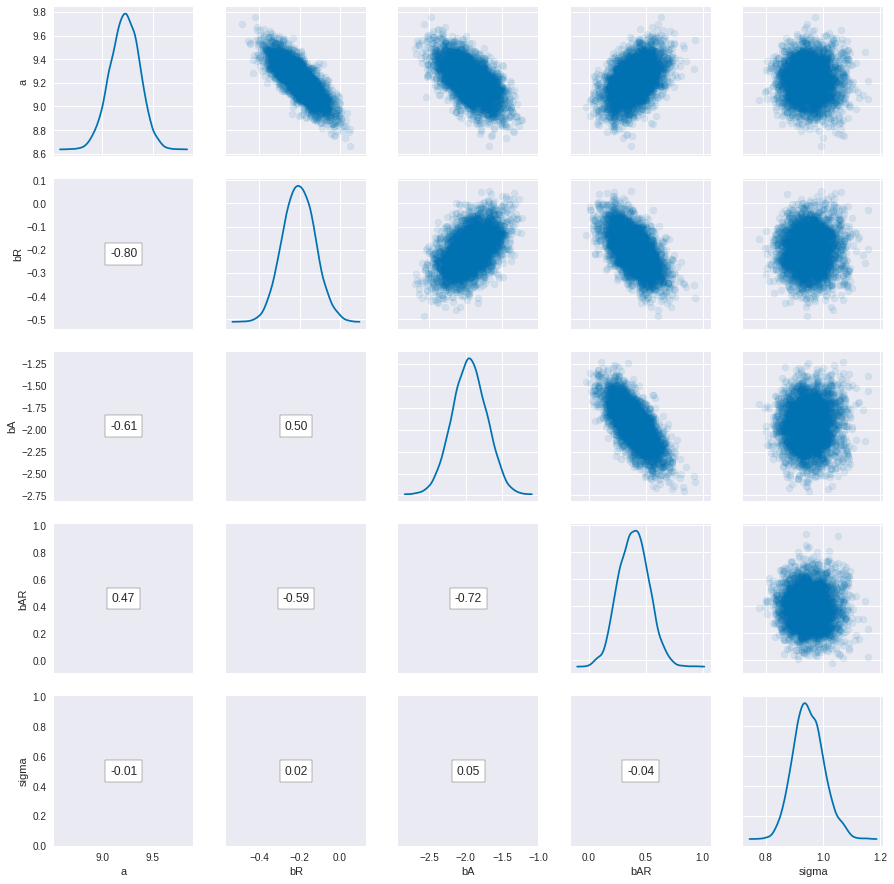

In [19]:
def plot_corr(x, y, **kwargs):
    corrcoeff = np.corrcoef(x, y)[0, 1]
    
    artist = AnchoredText('{:.2f}'.format(corrcoeff), loc=10)
    plt.gca().add_artist(artist)
    plt.grid(b=False)

trace_8_1_df = pm.trace_to_dataframe(trace_8_1_4_chains)
grid = (sns.PairGrid(trace_8_1_df,
                     x_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     y_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1)
           .map_lower(plot_corr))

#### Code 8.11

In [20]:
m8_1.logp({
    varname: trace_8_1[varname].mean()
        for varname in trace_8_1.varnames
})

array(-246.04094964741404)

In [21]:
with m8_1:
    print(pm.dic(trace_8_1))

502.379969031


In [22]:
with m8_1:
    print(pm.waic(trace_8_1))

WAIC_r(WAIC=469.60572680239341, WAIC_se=14.755676313845425, p_WAIC=5.2402148070767041)


/opt/conda/lib/python3.6/site-packages/pymc3/stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


#### Code 8.12

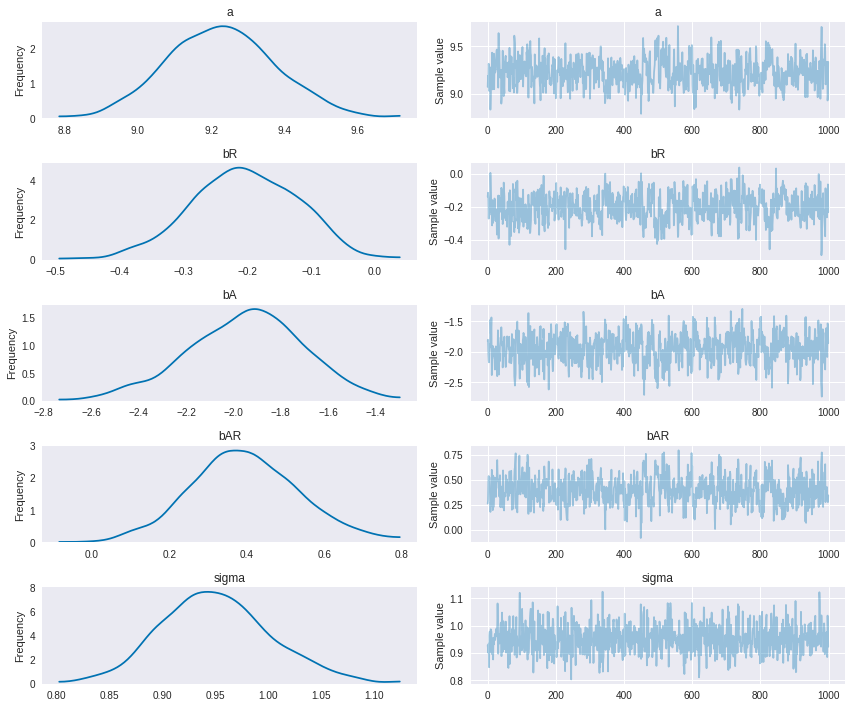

In [23]:
pm.traceplot(trace_8_1);

#### Code 8.13

In [24]:
y = np.array([-1., 1.])

with pm.Model() as m8_2:
    alpha = pm.Flat('alpha')
    sigma = pm.Bound(pm.Flat, lower=0.)('sigma')
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)

In [25]:
with m8_2:
    trace_8_2 = pm.sample(draws=2000, tune=2000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 3972/4000 [00:20<00:00, 193.29it/s]/opt/conda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.59702344488, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/opt/conda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 254 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 4000/4000 [00:20<00:00, 194.10it/s]
/opt/conda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/opt/conda/lib/python3.6/site-packages/pymc3/ste

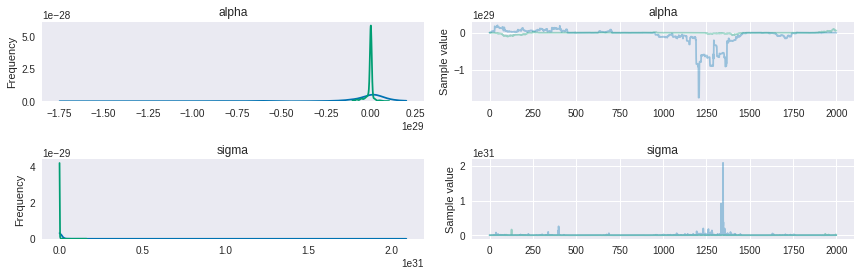

In [26]:
pm.traceplot(trace_8_2);

In [27]:
pm.effective_n(trace_8_2)

{'alpha': 18.0, 'sigma': 590.0}

#### Code 8.14

In [28]:
pm.df_summary(trace_8_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-3.661508e+27,1.570471e+28,1.447956e+27,-2.282993e+28,1.589588e+28
sigma,3.742035e+28,4.015276e+29,1.445345e+28,2.721364e+23,1.116235e+29


In [29]:
pm.gelman_rubin(trace_8_2)

{'alpha': 1.0419002817984018, 'sigma': 1.006029917815932}

#### Code 8.15

In [30]:
with pm.Model() as m8_3:
    alpha = pm.Normal('alpha', 1., 10.)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)

In [31]:
with m8_3:
    trace_8_3 = pm.sample(draws=3000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 4000/4000 [00:05<00:00, 747.62it/s]


In [32]:
pm.df_summary(trace_8_3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.080812,1.945431,0.073715,-3.588683,3.629072
sigma,2.186360,2.454558,0.071811,0.379396,5.597355


In [33]:
pm.effective_n(trace_8_3)

{'alpha': 680.0, 'sigma': 1029.0}

In [34]:
pm.gelman_rubin(trace_8_3)

{'alpha': 0.99983335966471443, 'sigma': 1.001917788640043}

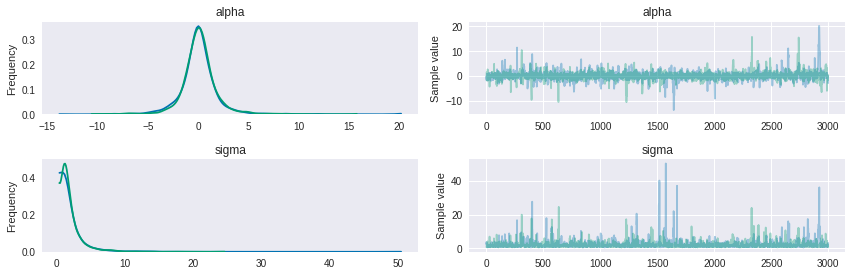

In [35]:
pm.traceplot(trace_8_3);

#### Code 8.16

In [36]:
y = sp.stats.cauchy.rvs(0., 5., size=int(1e4))
mu = y.cumsum() / (1 + np.arange(int(1e4)))

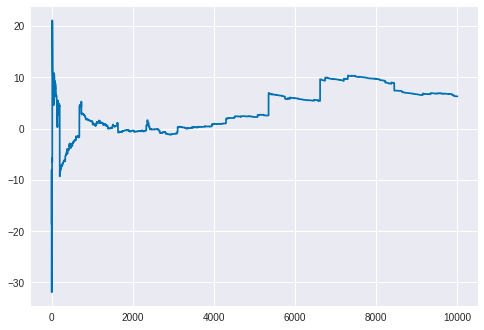

In [37]:
plt.plot(mu);

#### Code 8.17

In [38]:
y = np.random.normal(0., 1., size=100)

#### Code 8.18

In [39]:
with pm.Model() as m8_4:
    a1 = pm.Flat('a1')
    a2 = pm.Flat('a2')
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', a1 + a2, sigma, observed=y)

In [40]:
with m8_4:
    trace_8_4 = pm.sample(draws=3000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 3990/4000 [01:54<00:00, 34.80it/s]/opt/conda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0534162095919, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/opt/conda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 1566 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 4000/4000 [01:54<00:00, 34.88it/s]
/opt/conda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)


In [41]:
pm.df_summary(trace_8_4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a1,-81.102012,1019.731679,101.620687,-1058.708166,1445.130310
a2,81.129078,1019.734052,101.620918,-1445.048872,1058.673977
sigma,0.945024,0.092978,0.008299,0.867054,1.122579


In [42]:
pm.effective_n(trace_8_4)

{'a1': 1.0, 'a2': 1.0, 'sigma': 1.0}

In [43]:
pm.gelman_rubin(trace_8_4)

{'a1': 4.7125597907698715,
 'a2': 4.7125873893620387,
 'sigma': 2.3118216983054491}

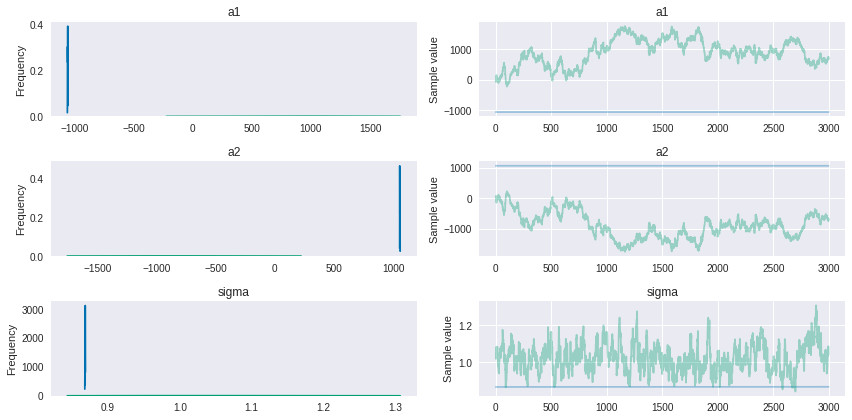

In [44]:
pm.traceplot(trace_8_4);

#### Code 8.19

In [45]:
with pm.Model() as m8_5:
    a1 = pm.Normal('a1', 0., 10.)
    a2 = pm.Normal('a2', 0., 10.)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', a1 + a2, sigma, observed=y)

In [46]:
with m8_5:
    trace_8_5 = pm.sample(draws=3000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 4000/4000 [02:00<00:00, 33.11it/s]


In [47]:
pm.df_summary(trace_8_5)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a1,0.186411,7.044018,0.183023,-13.638519,14.138751
a2,-0.161678,7.047275,0.182932,-14.060925,13.738993
sigma,1.023210,0.073460,0.001700,0.879604,1.161882


In [48]:
pm.effective_n(trace_8_5)

{'a1': 1354.0, 'a2': 1356.0, 'sigma': 2182.0}

In [49]:
pm.gelman_rubin(trace_8_5)

{'a1': 1.0002295246068722,
 'a2': 1.0002318846125495,
 'sigma': 1.0000872690485949}

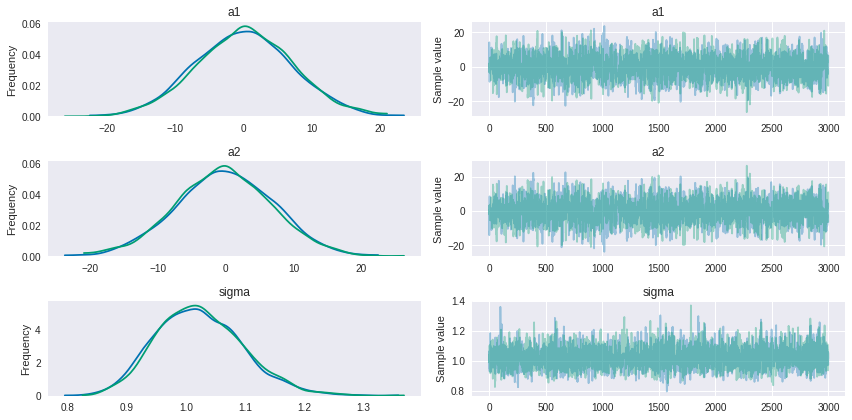

In [50]:
pm.traceplot(trace_8_5);